# Titanic Survival Prediction - Kaggle Competition

# Links
- [Titanic Kaggle Competition](https://www.kaggle.com/c/titanic/data)
- [Titanic Interactive Deckplans](https://www.encyclopedia-titanica.org/titanic-deckplans/d-deck.html)
- [Aquarel: An Open-Source Library for Matplotlib styling](https://github.com/lgienapp/aquarel)

### 1. Data Preprocess

Importing the data and converting it to a Pandas DataFrame for better readability.

In [38]:
import pandas as pd

df_train = pd.read_csv("Data/train.csv")
df_train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [39]:
# Adding the number of times a ticket was repeated to the dataframe
ticket_count = df_train["Ticket"].value_counts()
df_train["TicketCount"] = df_train["Ticket"].map(ticket_count)

# Adjusting the ticket price
df_train["AdjustedFare"] = df_train["Fare"] / df_train["TicketCount"]

# Introducing a new and more meaningful feature
df_train["Family"] = df_train["SibSp"] + df_train["Parch"]

# Extracting deck of residance for each passanger - N for NaN
df_train["Deck"] = df_train["Cabin"].str[0]
df_train["Deck"].fillna("NA", inplace=True)

# Removing unnecessary feature
df_train.drop(columns=["Name", "Ticket", "SibSp", "Parch", "Fare", "TicketCount", "Cabin"], inplace=True, errors='ignore')

# Replacing missing age values with the average
df_train["Age"].fillna(int(df_train["Age"].mean()), inplace=True)

# Defining a new feature - age group
age_bins = [0, 3, 12, 20, 60, 200]
age_labels = ["toddler", "child", "teen", "adult", "senior"]
df_train["AgeGroup"] = pd.cut(df_train["Age"], bins=age_bins, labels=age_labels)

# Replacing the missing embarked locations with the most frequent one
df_train["Embarked"].fillna(df_train["Embarked"].value_counts(ascending=False).index[0], inplace=True)

# Replacing embarked locations with their full name
location_dict = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
df_train["Embarked"].replace(location_dict, inplace=True)

df_train.head(6)

,PassengerId,Survived,Pclass,Sex,Age,Embarked,AdjustedFare,Family,Deck,AgeGroup
0,1,0,3,male,22.0,Southampton,7.2500,1,NA,adult
1,2,1,1,female,38.0,Cherbourg,71.2833,1,C,adult
2,3,1,3,female,26.0,Southampton,7.9250,0,NA,adult
3,4,1,1,female,35.0,Southampton,26.5500,1,C,adult
4,5,0,3,male,35.0,Southampton,8.0500,0,NA,adult
5,6,0,3,male,29.0,Queenstown,8.4583,0,NA,adult


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   891 non-null    int64   
 1   Survived      891 non-null    int64   
 2   Pclass        891 non-null    int64   
 3   Sex           891 non-null    object  
 4   Age           891 non-null    float64 
 5   Embarked      891 non-null    object  
 6   AdjustedFare  891 non-null    float64 
 7   Family        891 non-null    int64   
 8   Deck          891 non-null    object  
 9   AgeGroup      891 non-null    category
dtypes: category(1), float64(2), int64(4), object(3)
memory usage: 63.9+ KB


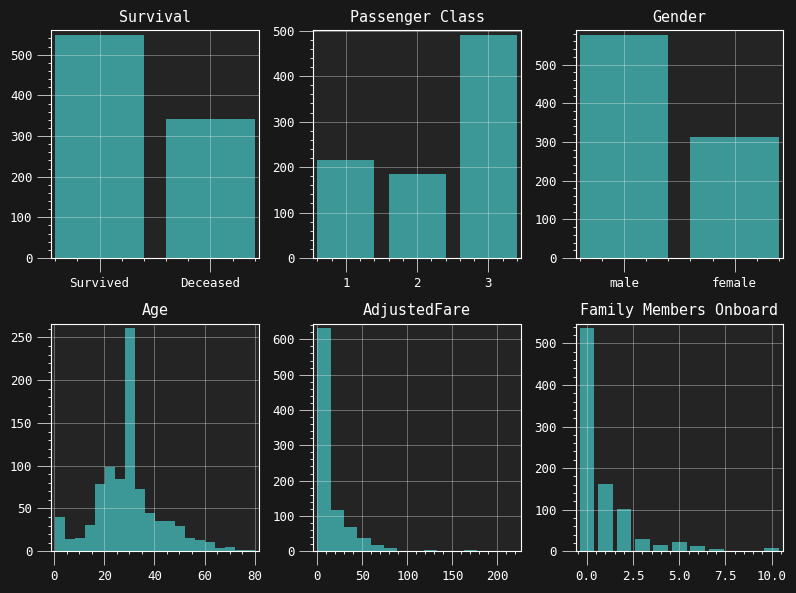

In [41]:
import matplotlib.pyplot as plt
from aquarel import load_theme

# Using the Aquarel library with some customization for the plots
theme = load_theme("boxy_dark")
theme.set_color(figure_background_color="#181818",
                plot_background_color="#242424")
theme.set_font(family="monospace", size=9)
theme.apply_transforms()
theme.apply()

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(8, 6))

survived = pd.DataFrame(df_train["Survived"].value_counts())
ax1.bar(["Survived", "Deceased"], survived['count'].values, label="Survived")
ax1.set_title("Survival", loc="center")

pclass = pd.DataFrame(df_train["Pclass"].value_counts())
ax2.bar(pclass.index, pclass['count'].values, label="Passenger Class")
ax2.set_title("Passenger Class", loc="center")

gender = pd.DataFrame(df_train["Sex"].value_counts())
ax3.bar(gender.index, gender['count'].values, label="Gender")
ax3.set_title("Gender", loc="center")

ax4.hist(df_train['Age'], bins=20, label="Age")
ax4.set_title("Age", loc="center")

ax5.hist(df_train['AdjustedFare'], bins=15, label="AdjustedFare")
ax5.set_title("AdjustedFare", loc="center")

family = pd.DataFrame(df_train["Family"].value_counts())
ax6.bar(family.index, family['count'].values, label="Family")
ax6.set_title("Family Members Onboard", loc="center")

fig.tight_layout();
plt.show(fig)

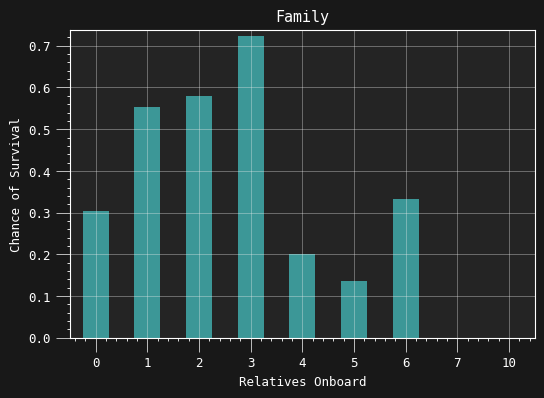

In [42]:
grouped_family = df_train.groupby("Family")["Survived"]
family_survival_rate = grouped_family.sum() / grouped_family.count()

grouped_family_plot = family_survival_rate.plot(
    kind="bar",
    ylabel="Chance of Survival",
    xlabel="Relatives Onboard",
    title="Family",
    rot=0,
    figsize=(6, 4))
plt.show(grouped_family_plot)

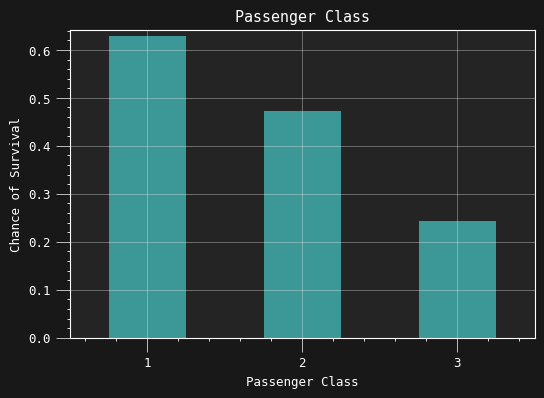

In [43]:
grouped_pclass = df_train.groupby("Pclass")["Survived"]
pclass_survival_rate = grouped_pclass.sum() / grouped_pclass.count()

grouped_pclass_plot = pclass_survival_rate.plot(
    kind="bar",
    ylabel="Chance of Survival",
    xlabel="Passenger Class",
    title="Passenger Class",
    rot=0,
    figsize=(6, 4))
plt.show(grouped_pclass_plot)

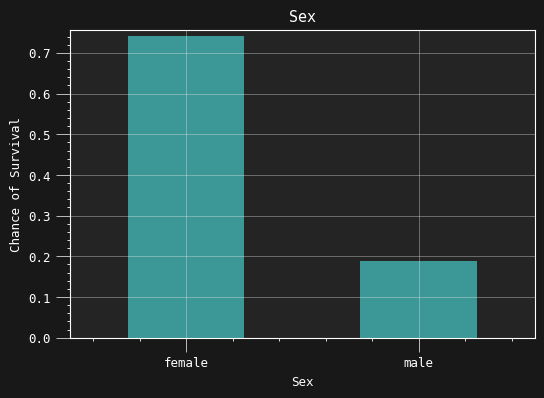

In [44]:
grouped_sex = df_train.groupby("Sex")["Survived"]
sex_survival_rate = grouped_sex.sum() / grouped_sex.count()

grouped_sex_plot = sex_survival_rate.plot(
    kind="bar",
    ylabel="Chance of Survival",
    xlabel="Sex",
    title="Sex",
    rot=0,
    figsize=(6, 4))
plt.show(grouped_sex_plot)

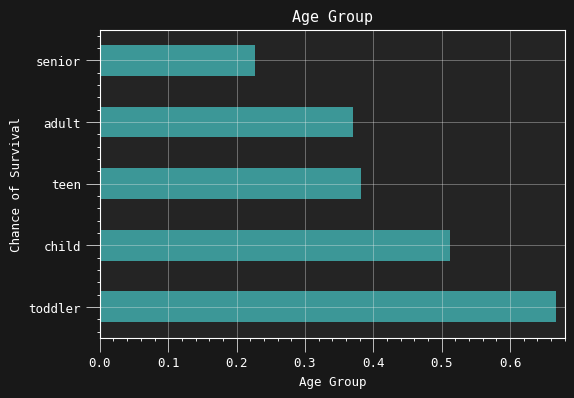

In [45]:
grouped_age = df_train.groupby("AgeGroup", observed=False)["Survived"]
age_survival_rate = grouped_age.sum() / grouped_age.count()

grouped_age_plot = age_survival_rate.plot(
    kind="barh",
    ylabel="Chance of Survival",
    xlabel="Age Group",
    title="Age Group",
    rot=0,
    figsize=(6, 4))

plt.show(grouped_age_plot)

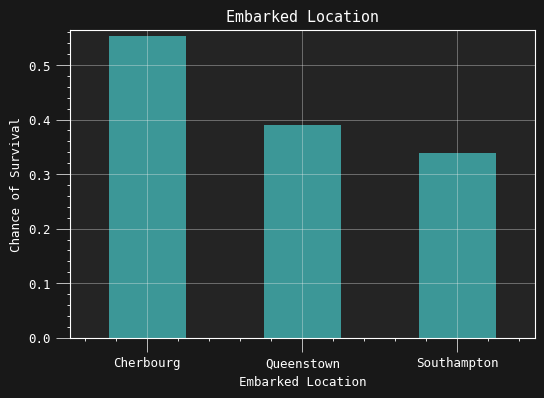

In [46]:
grouped_embarked = df_train.groupby("Embarked")["Survived"]
embarked_survival_rate = grouped_embarked.sum() / grouped_embarked.count()

grouped_embarked_plot = embarked_survival_rate.plot(
    kind="bar",
    ylabel="Chance of Survival",
    xlabel="Embarked Location",
    title="Embarked Location",
    rot=0,
    figsize=(6, 4))

plt.show(grouped_embarked_plot)

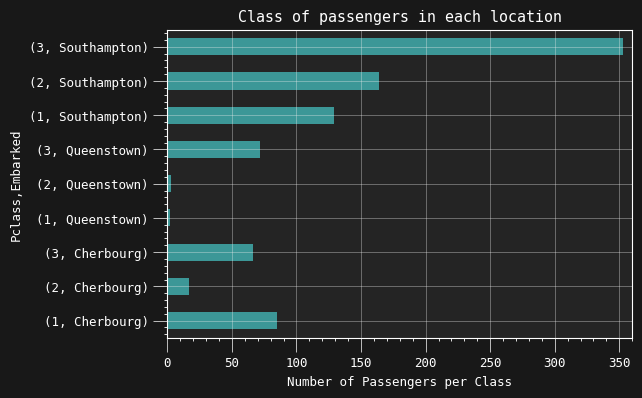

In [47]:
grouped_embarked_pclass = df_train.groupby("Pclass")["Embarked"].value_counts()
grouped_embarked_pclass = pd.DataFrame(grouped_embarked_pclass).sort_values(by=["Embarked", "Pclass"])

grouped_embarked_pclass_plot = grouped_embarked_pclass.plot(
    kind="barh",
    xlabel="Number of Passengers per Class",
    title="Class of passengers in each location",
    rot=0,
    legend=False,
    figsize=(6, 4))

plt.show(grouped_embarked_plot)

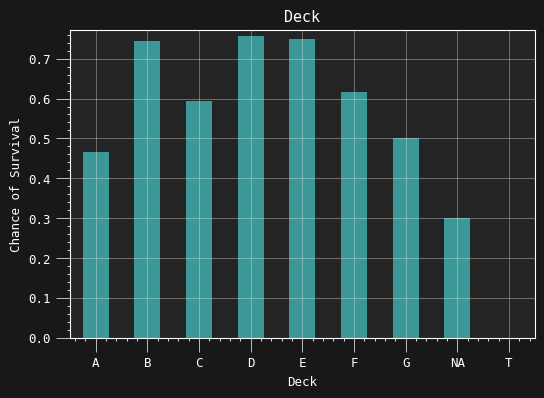

In [48]:
grouped_deck = df_train.groupby("Deck")["Survived"]
deck_survival_rate = grouped_deck.sum() / grouped_deck.count()

grouped_deck_plot = deck_survival_rate.plot(
    kind="bar",
    ylabel="Chance of Survival",
    xlabel="Deck",
    title="Deck",
    rot=0,
    figsize=(6, 4))

plt.show(grouped_age_plot)

In [49]:
def custome_ohe(df:pd.DataFrame, column:str, drop_original:bool=False):
    
    try:
        target_column = df[column]
        target_values = list(target_column.unique())
        for val in target_values:
            feature_title = f"{column}_{val}"
            df[feature_title] = df[column].map(
                lambda x: 1 if x == val else 0
            )
        if drop_original == True:
            df.drop(columns=[column], inplace=True, errors="ignore")
    except:
        if column not in df.columns:
            print(f"Column {column} does not exist in the dataframe.")
        else:
            print("The function is unable to one-hot-encode the column.")
        
        
custome_ohe(df=df_train, column="Embarked", drop_original=True)
custome_ohe(df=df_train, column="AgeGroup", drop_original=True)
custome_ohe(df=df_train, column="Deck", drop_original=True)

df_train["Sex"].replace({"male": 0, "female": 1}, inplace=True)

df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,AdjustedFare,Family,Embarked_Southampton,Embarked_Cherbourg,Embarked_Queenstown,...,AgeGroup_senior,Deck_NA,Deck_C,Deck_E,Deck_G,Deck_D,Deck_A,Deck_B,Deck_F,Deck_T
0,1,0,3,0,22.0,7.2500,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,1,1,1,38.0,71.2833,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,3,1,3,1,26.0,7.9250,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,1,1,1,35.0,26.5500,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,5,0,3,0,35.0,8.0500,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


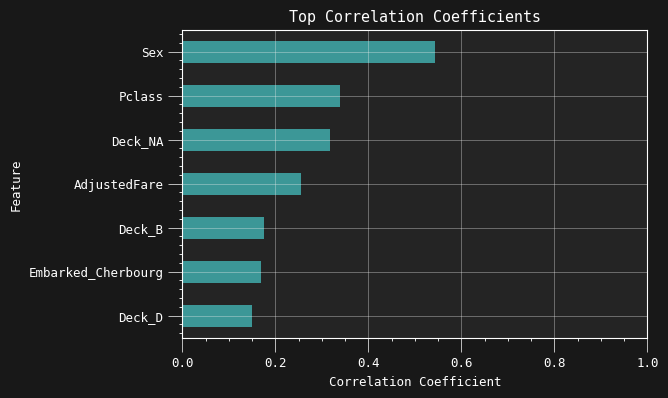

In [50]:
df_train_corr = df_train.corr()
corr_fig_top = abs(df_train_corr["Survived"]).sort_values()[-8:-1].plot(
    kind="barh",
    xlabel="Correlation Coefficient",
    ylabel="Feature",
    xlim=[0, 1],
    title="Top Correlation Coefficients",
    figsize=(6, 4))

plt.show(corr_fig_top)

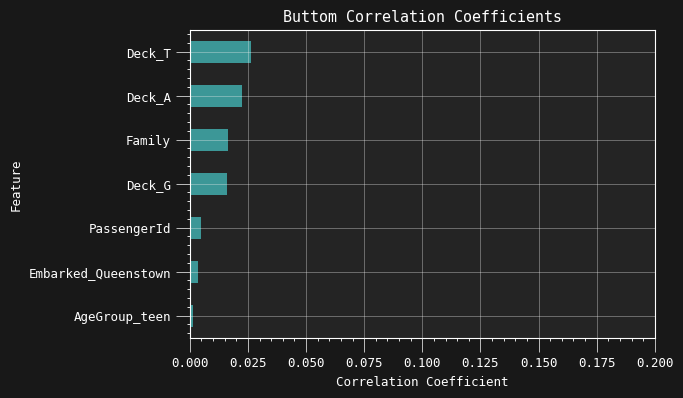

In [51]:
corr_fig_buttom = abs(df_train_corr["Survived"]).sort_values()[:7].plot(
    kind="barh",
    xlabel="Correlation Coefficient",
    ylabel="Feature",
    xlim=[0, 0.2],
    title="Buttom Correlation Coefficients",
    figsize=(6, 4))

plt.show(corr_fig_buttom)

In [52]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,AdjustedFare,Family,Embarked_Southampton,Embarked_Cherbourg,Embarked_Queenstown,...,AgeGroup_senior,Deck_NA,Deck_C,Deck_E,Deck_G,Deck_D,Deck_A,Deck_B,Deck_F,Deck_T
0,1,0,3,0,22.0,7.2500,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,1,1,1,38.0,71.2833,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,3,1,3,1,26.0,7.9250,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,1,1,1,35.0,26.5500,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,5,0,3,0,35.0,8.0500,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [53]:
df_train["AdjustedFare"].replace(0, df_train["AdjustedFare"].median(), inplace=True)
df_train[df_train["AdjustedFare"] == 0]

,PassengerId,Survived,Pclass,Sex,Age,AdjustedFare,Family,Embarked_Southampton,Embarked_Cherbourg,Embarked_Queenstown,...,AgeGroup_senior,Deck_NA,Deck_C,Deck_E,Deck_G,Deck_D,Deck_A,Deck_B,Deck_F,Deck_T


In [54]:
import numpy as np

df_train["AdjustedFare"] = df_train["AdjustedFare"].map(lambda x: np.log(x))

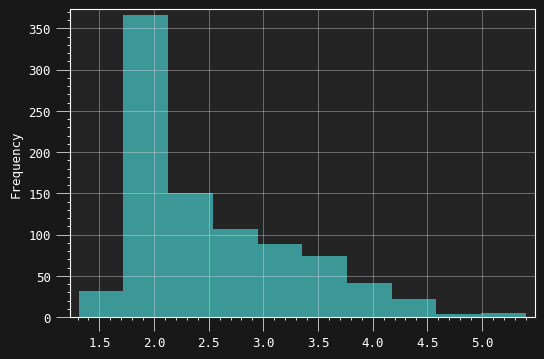

In [55]:
log_fare_plot = df_train["AdjustedFare"].plot(kind="hist", bins=10, figsize=(6, 4))
plt.show(log_fare_plot)